In [14]:
import gymnasium as gym
import numpy as np
gym.__version__

'0.29.0'

In [2]:
env = gym.make("LunarLander-v2")

From [docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


In [3]:
env.action_space

Discrete(4)


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [4]:
print(env.observation_space.shape)
env.observation_space

(8,)


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

## Taking a step

In [5]:
env.reset()
observation, reward, terminated, truncated, info = env.step(0)

## Reinforcement Learning Objective

Our performance measure: 

$$
J(\theta) = \mathbb{E} \left[ \sum_{t=0}^{T-1}r_{t+1} \right]
$$

and our update rule:

$$
\theta \leftarrow \theta + \frac{\partial}{\partial \theta} J(\theta)
$$

The gradient
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a q_\pi(S_t, a) \nabla \pi (a | S_t, \theta) \right]
$$
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

If we sample $A_t \sim \pi$, then we just replace the expectation over $a$ with the sample $A_t$. So we're doing this swap from expectation to sample:
$$
\sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \rightarrow q_\pi(S_t, A_t)
$$
which then simplifies $\nabla J(\theta)$ to

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ q_\pi(S_t, A_t) \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

and by $\mathbb{E}_\pi [G_t | S_t, A_t] = q_\pi (S_t, A_t)$,

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

We're going to make one more simplification: note that $\nabla \ln x = \frac{\nabla x}{x}$, so
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \nabla \ln \pi (a | S_t, \theta) \right]
$$

Now, we can actually calculate the value in brackets at each time step, and can then use it to update $\theta$:

$$
\theta_{t+1} = \theta_t + \alpha G_t \nabla \ln \pi(A_t | S_t, \theta_t)
$$

We're now going to generate an episode $S_0, A_0, R_1,...,S_{T-1}, A_{T-1}, R_T$.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.w = nn.Linear(shape[0], shape[1])
        self.layer = nn.Sequential(
            self.w,
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(network_shape)

Here is a full episode of the moon landing.

In [17]:
def run_episode(model, env=env):
    observation, _ = env.reset()
    step = 0

    rewards = []
    log_probs = []

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        log_probs.append(_log_probs)

        if terminated:
            observation = env.reset()
            break
        step += 1

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs

rewards, log_probs = run_episode(model)

Now, at the end of the episode, we need to determine $G$, the rewards after the end of each episode.

In [18]:
def discount_rewards(rewards, gamma):
    discounted_rewards = torch.zeros_like(rewards)
    R = 0
    for t in reversed(range(len(rewards))):
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
    return discounted_rewards

gamma = 0.99
d_rewards = discount_rewards(rewards, gamma)

In [19]:
def update(model, log_probs, d_rewards, alpha=0.01):
    for (t,(log_prob, reward)) in enumerate(zip(log_probs, d_rewards.tolist())):
        model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in model.parameters():
            if param.grad is not None:
                param.grad = param.grad * reward * gamma**t * alpha # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        model.optimizer.step() # update the weights using the gradients

update(model, log_probs, d_rewards)

And now we'll try it for a bunch of episodes.

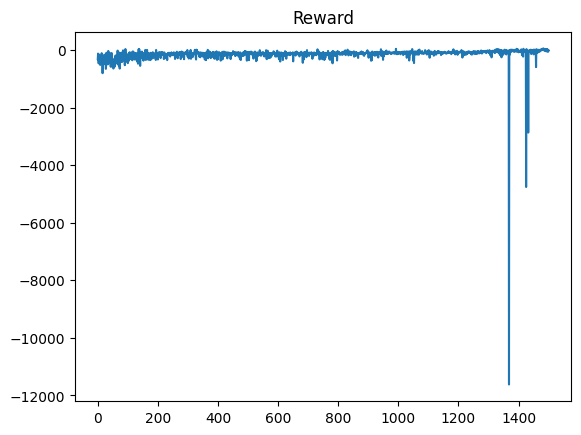

In [46]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(network_shape)

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(100000):
    rewards, log_probs = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update(model, log_probs, d_rewards)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")
        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break